In [1]:
#Simulation settings
num_rounds = 10 # Number of communication rounds
num_devices = 2 # Number of devices
bs = 50 # Batch size for local training at devices
ep = 2 # Number of local epochs before communication round
filename = "0.1-noise-2-devices"

In [2]:
#Load MNIST dataset
import tensorflow as tf
import time

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255, x_test/255

num_samples = len(x_train)

#Split dataset into shards
samples_per_shard = int(num_samples/num_devices)
x_train_shards = []
y_train_shards = []
for i in range(num_devices):
    x_train_shard = x_train[i*samples_per_shard:(i+1)*samples_per_shard]
    x_train_shards.append(x_train_shard)
    y_train_shard = y_train[i*samples_per_shard:(i+1)*samples_per_shard]
    y_train_shards.append(y_train_shard)

print("Dataset loaded.")

Dataset loaded.


In [3]:
#Set up DNN models
model_template = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

model_list = []

for i in range(num_devices):
    model_list.append(tf.keras.models.clone_model(model_template))

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

for model in model_list:
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [4]:
#Train DNN
acc_history = []
for r in range(num_rounds):
    print("Communication round " + str(r+1) + "/" + str(num_rounds))
    start = time.time()
    #Train using local dataset
    for d in range(num_devices): #TODO: Parallelize
        model_list[d].fit(x_train_shards[d], y_train_shards[d], batch_size=bs, epochs=ep, verbose=0)
    #Calculate weight average
    average_weights = model_list[0].get_weights()
    for d in range(num_devices): #This could be done in a faster way
        if d == 0:
            continue
        weights = model_list[d].get_weights()
        for l in range(len(average_weights)):
            average_weights[l] = average_weights[l] + weights[l]
    for l in range(len(average_weights)):
            average_weights[l] = average_weights[l]/num_devices
    
    #Set model of all devices to the average
    for model in model_list:
        model.set_weights(average_weights)
    acc_history.append(model_list[0].evaluate(x_test, y_test, verbose=0)[1])
    print(str(int(time.time()-start)) + " seconds elapsed\n")
    
print("Final accuracy", acc_history[-1])

Communication round 1/10
4 seconds elapsed

Communication round 2/10
3 seconds elapsed

Communication round 3/10
3 seconds elapsed

Communication round 4/10
3 seconds elapsed

Communication round 5/10
3 seconds elapsed

Communication round 6/10
3 seconds elapsed

Communication round 7/10
3 seconds elapsed

Communication round 8/10
3 seconds elapsed

Communication round 9/10
3 seconds elapsed

Communication round 10/10
3 seconds elapsed

Final accuracy 0.9807999730110168


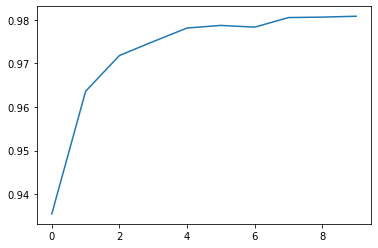

In [5]:
#Plot accuracy
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(range(len(acc_history[0:])), acc_history[0:])
plt.savefig(filename, format='png')

In [16]:
print(y_train_shards[0][0:50])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 9 3]
